In [1]:
# This notebook is used for testing plant models in the sirasi module.

# By Sergio Verduzco Flores        June 2017

from sirasi import *
from matplotlib import pyplot as plt
import pylab
import re

In [2]:
def loadData(filename):
    # Receives the name of a datafile saved in XPP's .dat format, 
    # and returns numpy arrays with the data from the columns
    # The format is simply putting in each line the values of time and state variables
    # separated by spaces. Time is the first column.
    
    # Counting the lines and columns in order to allocate the numpy arrays
    nlines = sum(1 for line in open(filename,'r'))
    n_columns = len(re.split(' .', open(filename,'r').readline()))
    # XPP puts an extra space at the end of the line, so I used ' .' instead of ' '
    
    # We'll store everything in one tuple of numpy arrays, one per column
    values = tuple(np.zeros(nlines) for i in range(n_columns))
    for idx, line in enumerate(open(filename,'r')):
        listed = re.split(' ', re.split(' $', line)[0]) # the first split removes the trailing space
        for jdx, value in enumerate(listed):  
            values[jdx][idx] = float(value) 
            
    return values

In [3]:
'''
    This cell performs the same simulation as in the file pend.ode, which is one of the 
    examples distributed with XPPAUT. The next cell compares sirasi VS XPPAUT output. 
'''
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4 } # parameter dictionary for the network
n2 = network(net_params)

# Notice the XPP model uses a massless rod with a mass at the end, so I need length=2
# Moreover, the angles are measured wrt different axes, so init_angle = 2 - pi/2
params = {'type' : plant_models.pendulum, 'delay' : 0.1,
          'length' : 2., 'mass' : 10., 'mu' : 2.,
          'init_angle' : 2-(np.pi/2.), 'init_ang_vel' : 0.}
n2.create(1, params) # create a plant

# Run the simulation
sim_dat = n2.run(20.)

# In pend.ode the zero angle aligns with the negative Y axis
sim_dat[2][0][:,0] = sim_dat[2][0][:,0] + np.pi/2

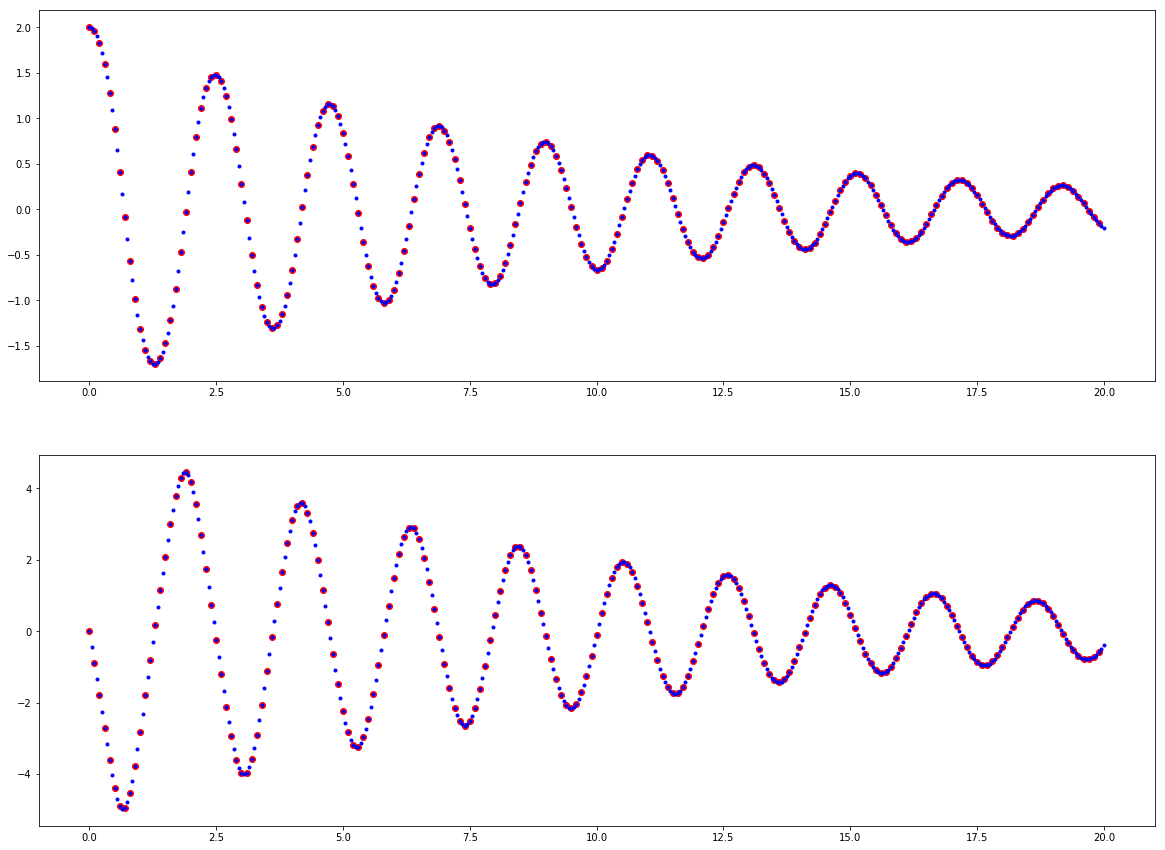

In [4]:
xpp_dat = loadData('./tests/pendoderun.dat')

fig = plt.figure(figsize=(20,15))
plt.subplot(211)
pylab.plot(sim_dat[0], sim_dat[2][0][:,0], 'ro', xpp_dat[0], xpp_dat[1], 'b.', figure=fig)
plt.subplot(212)
pylab.plot(sim_dat[0], sim_dat[2][0][:,1], 'ro', xpp_dat[0], xpp_dat[2], 'b.', figure=fig)
plt.show()